# WLS-ENO方法

已知未知量在网格单元内的平均值$\overline{f}_i$

- 根据一定的计算模版$\{I_j:j \in S_i\}$重构出网格单元$i$的近似分布$\tilde{f}_i(x)$

$$\overline{f}_i = \frac{1}{\vert \Omega_i \vert} \int_{\Omega_i} \tilde{f}_i(x) dx$$

其中$S_i$是网格单元$i$的邻居单元编号集合，也即是计算模版，$\vert \Omega_i \vert$是网格单元$i$的体积

- 在两个网格单元的交界面会得到两个值$q^-$和$q^+$，用来计算数值通量

- $p$次多项式形式为

$$\tilde{f}_i(x) = c_0 + c_1 x + c_2 x^2 + \dots + c_p x^p$$



In [1]:
from numpy import linspace, arange, float64, zeros, sin, pi, poly1d, abs, max
from numpy.linalg import lstsq
import matplotlib.pyplot as plt

# 设置计算参数

In [2]:
nx = 64     # Grid number
np = 9      # Polynomial degree
ns = 13     # Stencil width
dt = 0.0005 # Time step size (s)
nt = 2 / dt # Time step number

# 设置内部常数

通信边界宽度

In [367]:
nh = int((ns - 1) / 2)

网格编号边界（用于取实际计算网格）

In [368]:
ib = nh
ie = nx + nh # +1

计算模版中心的相对编号

In [369]:
s0 = nh

# 设置网格

这里先假设是等距网格

In [370]:
min_x = -1
max_x =  1

In [371]:
dx = (max_x - min_x) / nx
dx

0.03125

网格中心点坐标

In [372]:
x = arange(min_x - dx * nh, max_x + dx * nh, dx, dtype=float64)
x

array([-1.1875 , -1.15625, -1.125  , -1.09375, -1.0625 , -1.03125,
       -1.     , -0.96875, -0.9375 , -0.90625, -0.875  , -0.84375,
       -0.8125 , -0.78125, -0.75   , -0.71875, -0.6875 , -0.65625,
       -0.625  , -0.59375, -0.5625 , -0.53125, -0.5    , -0.46875,
       -0.4375 , -0.40625, -0.375  , -0.34375, -0.3125 , -0.28125,
       -0.25   , -0.21875, -0.1875 , -0.15625, -0.125  , -0.09375,
       -0.0625 , -0.03125,  0.     ,  0.03125,  0.0625 ,  0.09375,
        0.125  ,  0.15625,  0.1875 ,  0.21875,  0.25   ,  0.28125,
        0.3125 ,  0.34375,  0.375  ,  0.40625,  0.4375 ,  0.46875,
        0.5    ,  0.53125,  0.5625 ,  0.59375,  0.625  ,  0.65625,
        0.6875 ,  0.71875,  0.75   ,  0.78125,  0.8125 ,  0.84375,
        0.875  ,  0.90625,  0.9375 ,  0.96875,  1.     ,  1.03125,
        1.0625 ,  1.09375,  1.125  ,  1.15625])

网格边界坐标

In [373]:
xi = arange(x[0] - dx / 2, x[-1] + dx / 2, dx, dtype=float64)
xi

array([-1.203125, -1.171875, -1.140625, -1.109375, -1.078125, -1.046875,
       -1.015625, -0.984375, -0.953125, -0.921875, -0.890625, -0.859375,
       -0.828125, -0.796875, -0.765625, -0.734375, -0.703125, -0.671875,
       -0.640625, -0.609375, -0.578125, -0.546875, -0.515625, -0.484375,
       -0.453125, -0.421875, -0.390625, -0.359375, -0.328125, -0.296875,
       -0.265625, -0.234375, -0.203125, -0.171875, -0.140625, -0.109375,
       -0.078125, -0.046875, -0.015625,  0.015625,  0.046875,  0.078125,
        0.109375,  0.140625,  0.171875,  0.203125,  0.234375,  0.265625,
        0.296875,  0.328125,  0.359375,  0.390625,  0.421875,  0.453125,
        0.484375,  0.515625,  0.546875,  0.578125,  0.609375,  0.640625,
        0.671875,  0.703125,  0.734375,  0.765625,  0.796875,  0.828125,
        0.859375,  0.890625,  0.921875,  0.953125,  0.984375,  1.015625,
        1.046875,  1.078125,  1.109375,  1.140625])

# 边界条件

In [374]:
def periodic_boundary(nh, f):
    f[:nh] = f[len(f)-2*nh:len(f)-nh]
    f[len(f)-nh:] = f[nh:2*nh]

# 重构矩阵

重构矩阵的维度大小为$(模版大小,多项式次数+1)$，以一维情况为例：
$$
\mathbf{R} = \left[ \begin{array}{cccc}
  \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}} - x_{i-s-\frac{1}{2}}\right) & \frac{1}{2} \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}}^2 - x_{i-s-\frac{1}{2}}^2\right) & \dots & \frac{1}{p+1} \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}}^{p+1} - x_{i-s-\frac{1}{2}}^{p+1}\right) \\
  \vdots & \vdots & \vdots & \vdots \\
  \frac{1}{\Delta{x}_{i}} \left(x_{i+\frac{1}{2}} - x_{i-\frac{1}{2}}\right) & \frac{1}{2} \frac{1}{\Delta{x}_{i}} \left(x_{i+\frac{1}{2}}^2 - x_{i-\frac{1}{2}}^2\right) & \dots & \frac{1}{p+1} \frac{1}{\Delta{x}_{i}} \left(x_{i+\frac{1}{2}}^{p+1} - x_{i-\frac{1}{2}}^{p+1}\right) \\
  \vdots & \vdots & \vdots & \vdots \\
  \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}} - x_{i-s-\frac{1}{2}}\right) & \frac{1}{2} \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}}^2 - x_{i-s-\frac{1}{2}}^2\right) & \dots & \frac{1}{p+1} \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}}^{p+1} - x_{i-s-\frac{1}{2}}^{p+1}\right)
\end{array} \right]
$$

其中$s$是网格单元$i$一侧的邻居网格数量。

$$\min \|\mathbf{W} \mathbf{R} \mathbf{c} - \mathbf{W} \overline{\mathbf{f}}\|_2$$

其中$\mathbf{W}$是对角权重矩阵，维度大小为$(模版大小,模版大小)$，向量$\mathbf{c}$是待求重构系数或多项式系数。

In [375]:
R = zeros([ns, np+1])

for j in range(ns):
    # Relative coordinate (assume uniform grid interval)
    #
    #        o           o     ...    o    ...    o           o
    #  -(ns-1)/2*dx                   0                  (ns-1)/2*dx
    #
    xj = (j - s0) * dx
    xl = xj - dx / 2
    xr = xj + dx / 2
    print(j, xl, xj, xr)
    for p in range(np+1):
        R[j,p] = (xr**(p + 1) - xl**(p + 1)) / (p + 1) / dx

0 -0.203125 -0.1875 -0.171875
1 -0.171875 -0.15625 -0.140625
2 -0.140625 -0.125 -0.109375
3 -0.109375 -0.09375 -0.078125
4 -0.078125 -0.0625 -0.046875
5 -0.046875 -0.03125 -0.015625
6 -0.015625 0.0 0.015625
7 0.015625 0.03125 0.046875
8 0.046875 0.0625 0.078125
9 0.078125 0.09375 0.109375
10 0.109375 0.125 0.140625
11 0.140625 0.15625 0.171875
12 0.171875 0.1875 0.203125


# 初始条件

## 方波

In [377]:
def square_initial_condition(x):
    f = zeros(len(x))
    for i in range(len(x)):
        if -0.4 <= x[i] <= 0.4: f[i] = 1
    return f

## 正弦函数

In [378]:
def sine_initial_condition(x):
    f = sin(x / (max_x - min_x) * 2 * pi)
    return f

# 设置速度

u = zeros(len(xi))

## 常速度

In [379]:
u[:] = 1

# 一维平流空间算子

使用了Lax-Friedrichs通量分裂算法

$$F_{i+\frac{1}{2}} = \frac{1}{2} \left[\left(F(f_{i+\frac{1}{2}}^-) + F(f_{i+\frac{1}{2}}^+)\right) - \alpha \left(f_{i+\frac{1}{2}}^+ - f_{i+\frac{1}{2}}^-\right)\right]$$

其中$f_{i+\frac{1}{2}}^-$和$f_{i+\frac{1}{2}}^+$是边界$i+\frac{1}{2}$上左边值（来自网格单元$i$的重构）和右边值（来自网格单元$i+1$的重构）。

In [386]:
def space_operator(nx, x, dx, f):
    eps = 1.0e-5
    alpha = 10
    
    fl = zeros(len(x))
    fr = zeros(len(x))
    for i in range(ib, ie):
        fs = zeros(ns) # Stencil values
        si = zeros(ns) # Smoothness indicator
        for j in range(ns):
            fs[j] = f[i-nh+j]
            si[j] = (fs[j] - f[i])**2 + eps * (x[i-nh+j] - x[i])**2
        si[s0] = min(si[s0-1], si[s0+1])
        
        W = zeros([ns, ns])
        for j in range(ns):
            W[j,j] = 1 / si[j]
        W[s0,s0] *= alpha
        
        c = lstsq(W.dot(R), W.dot(fs), rcond=None)[0]
        fpoly = poly1d(list(reversed(c)))
        
        # Get the values of left and right edges of cell i.
        fl[i] = fpoly(-dx / 2)
        fr[i] = fpoly( dx / 2)

    # Apply boundary conditions.
    periodic_boundary(1, fl[ib-1:ie+1])
    
    # Calculate numerical flux at right interfaces of cells.
    F = zeros(nx+2)
    F[1:nx] = 0.5 * (u[ib+1:ie] * (fl[ib+1:ie] + fr[ib:ie-1]) - max(abs(u)) * (fl[ib+1:ie] - fr[ib:ie-1]))
    periodic_boundary(1, F)
    dFdx = (F[1:-1] - F[:-2]) / dx
    return dFdx

In [387]:
space_operator(nx, x, dx, f).shape

(64,)

# 时间积分方案

In [388]:
def update(dt, dFdx, f):
    f_new = f
    f_new[ib:ie] = f[ib:ie] - dt * dFdx
    periodic_boundary(nh, f_new)
    return f_new

## 四阶Runge-Kutta

In [389]:
def rk4(nx, x, dx, dt, f):
    dFdx1 = space_operator(nx, x, dx, f)
    f2 = update(0.5 * dt, dFdx1, f)

    dFdx2 = space_operator(nx, x, dx, f2)
    f3 = update(0.5 * dt, dFdx2, f)

    dFdx3 = space_operator(nx, x, dx, f3)
    f4 = update(dt, dFdx3, f)

    dFdx4 = space_operator(nx, x, dx, f4)

    dFdx = (dFdx1 + 2 * dFdx2 + 2 * dFdx3 + dFdx4) / 6

    return update(dt, dFdx, f)

# 运行模拟

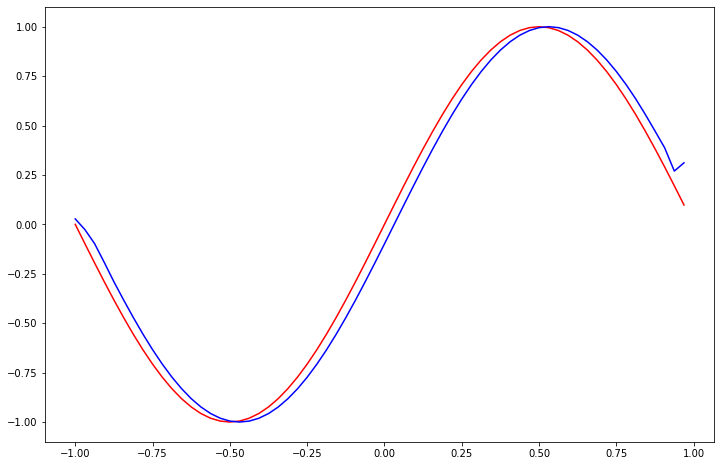

In [391]:
f = sine_initial_condition(x)

plt.figure(figsize=(12, 8))
plt.plot(x[ib:ie], f[ib:ie], color='red')

t = 0
while t <= 20:
    f = rk4(nx, x, dx, dt, f)
    t += 1

plt.plot(x[ib:ie], f[ib:ie], color='blue')
plt.draw()

In [385]:
1 * dt / dx

0.016